reference : https://www.kaggle.com/soumya044/artistic-neural-style-transfer-using-pytorch/data


Handling the imports.

In [2]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

Loading in VGG19.

In [3]:
vgg = models.vgg19(pretrained=True).features

# we dont want to train vgg parameters
for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

putting stuff onto gpu if available.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Load content and style images.

In [7]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    
    if max(image.size) >  max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([transforms.Resize(size),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406),
                                                            (0.229, 0.224, 0.225 ))])
    image = in_transform(image)[:3, :,:].unsqueeze(0)
    
    return image

Downloading the required image.

In [13]:
!wget https://oceanmhs.org/wp-content/uploads/2018/01/starrynight.jpg
!wget https://image.redbull.com/rbcom/010/2014-09-26/1331681214245_2/0100/0/1/call-of-duty-ghosts.jpg

--2021-03-15 05:11:48--  https://oceanmhs.org/wp-content/uploads/2018/01/starrynight.jpg
Resolving oceanmhs.org (oceanmhs.org)... 104.155.134.146
Connecting to oceanmhs.org (oceanmhs.org)|104.155.134.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92567 (90K) [image/jpeg]
Saving to: ‘starrynight.jpg’

starrynight.jpg     100%[===================>]  90.40K   258KB/s    in 0.3s    

2021-03-15 05:11:49 (258 KB/s) - ‘starrynight.jpg’ saved [92567/92567]

--2021-03-15 05:11:50--  https://image.redbull.com/rbcom/010/2014-09-26/1331681214245_2/0100/0/1/call-of-duty-ghosts.jpg
Resolving image.redbull.com (image.redbull.com)... 23.203.101.79
Connecting to image.redbull.com (image.redbull.com)|23.203.101.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.redbull.com/images/f_auto,q_auto/redbullcom/2014/09/26/1331681214245_2/call-of-duty-ghosts.jpg [following]
--2021-03-15 05:11:50--  https://img.redbull.com/ima

In [18]:
!wget -O "sekiro.jpg" "https://swall.teahub.io/photos/small/54-541394_sekiro-shadows-die-twice.jpg"

--2021-03-15 05:15:19--  https://swall.teahub.io/photos/small/54-541394_sekiro-shadows-die-twice.jpg
Resolving swall.teahub.io (swall.teahub.io)... 198.204.234.172
Connecting to swall.teahub.io (swall.teahub.io)|198.204.234.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71844 (70K) [image/jpeg]
Saving to: ‘sekiro.jpg’

sekiro.jpg          100%[===================>]  70.16K   433KB/s    in 0.2s    

2021-03-15 05:15:20 (433 KB/s) - ‘sekiro.jpg’ saved [71844/71844]



In [19]:
!ls

 __notebook_source__.ipynb
 call-of-duty-ghosts.jpg
 sekiro.jpg
 sekiro.png
 starrynight.jpg
'url?sa=i&url=https:%2F%2Fwww.chaoshour.com%2Fgames%2Ffixes%2Fsekiro-shadows-die-twice-audio-sound-ps4-xbox-one-pc-fix%2F&psig=AOvVaw2WtTM3T17KjnEQzX8CUNvP&ust=1615871168741000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCMjCvKzDse8CFQAAAAAdAA'


Loading images to cpu and gpu.

In [21]:
content = load_image('sekiro.jpg').to(device)
print(content.shape)
style = load_image('starrynight.jpg', shape=content.shape[-2:]).to(device)
print(style.shape)

torch.Size([1, 3, 400, 711])
torch.Size([1, 3, 400, 711])


Normalisation function for image.

In [22]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485,0.456,0.406))
    image = image.clip(0,1)
    
    return image

Lets display the normalised image.

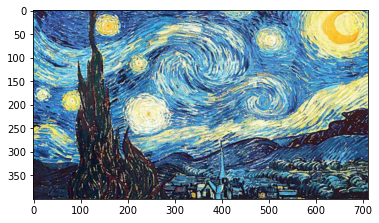

In [24]:
plt.imshow(im_convert(style))


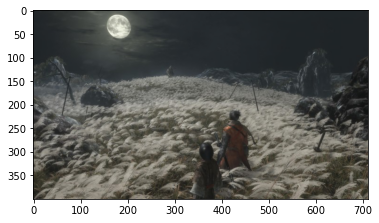

In [25]:
plt.imshow(im_convert(content))

VGG19 layers

In [26]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Lets map layer to names.

In [27]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
    features = {}
    x = image
    for name,layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

Calculating the Gram Matrix. 

Now what is Gram matrix? 

The output of every convolutional layer is a Tensor with dimensions associated with the batch_size, a depth, d and some height and width (h, w). The Gram matrix of a convolutional layer can be calculated as follows:

1. Get the depth, height, and width of a tensor using batch_size, d, h, w = tensor.size
2. Reshape that tensor so that the spatial dimensions are flattened
3. Calculate the gram matrix by multiplying the reshaped tensor by it's transpose
Note: You can multiply two matrices using torch.mm(matrix1, matrix2).

It is used for measuring style loss.

In [28]:
def gram_matrix(tensor):
    _,d,h,w = tensor.size()
    
    tensor = tensor.view(d, h* w)
    
    gram = torch.mm(tensor, tensor.t())
    
    return gram

Putting it all together.

In [29]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
target = content.clone().requires_grad_(True).to(device)

Loss and Weights.

These weights will define how much the features will be affected in the final image

In [31]:
style_weights = {'conv1_1' : 1.,
                 'conv2_1' : 0.75,
                 'conv3_1' : 0.2,
                 'conv4_1' : 0.2,
                 'conv5_1' : 0.2}

content_weight = 1
style_weight = 1e9

Updating the Target and Calculating Loss.

Loss in terms of content - loss between target and content features at layer conv4_2

style loss - compute the gram matric for target and style at each of the layer

total loss will be adding the style and content losses.

Total_loss:  1675151540224.0


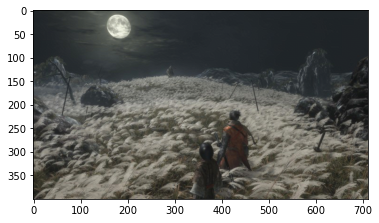

Total_loss:  1598919671808.0


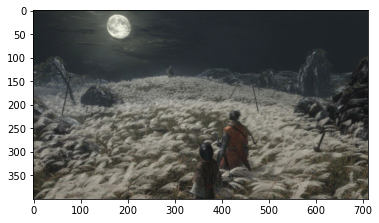

Total_loss:  1515586846720.0


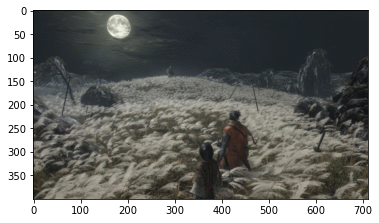

Total_loss:  1426856869888.0


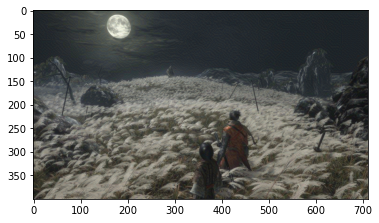

In [32]:
show_every  = 400

optimizer = optim.Adam([target], lr = 0.003)

steps = 2000

for ii in range(1, steps+1):
    target_features = get_features(target, vgg)
    
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    style_loss = 0
    
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if ii % show_every == 0:
        print('Total_loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()
    

Displaing the final target image

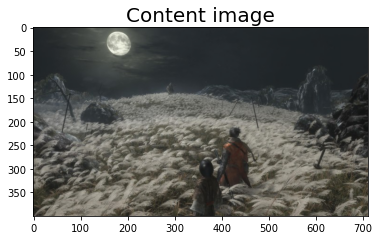

In [36]:
plt.figsize=(15,15)
plt.title("Content image", fontsize=18)
plt.imshow(im_convert(content))

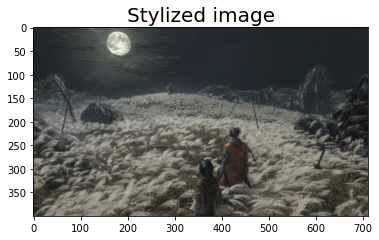

In [39]:
plt.title("Stylized image", fontsize=18)
plt.imshow(im_convert(target))